<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%9E%D1%82%D1%80%D1%8B%D0%B2_%D0%BE%D1%82_%D1%80%D0%B0%D0%B2%D0%BD%D0%BE%D0%B2%D0%B5%D1%81%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%9C%D0%B0%D1%80%D0%BA%D0%BE%D0%B2%D0%B5%D1%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [9]:
! pip install bt
! pip install git+https://github.com/prog815/progGA

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-oyp19yqn
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-oyp19yqn
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3733 sha256=c994d90e9bb2f5b7e3b1a9d0ad1cf1f5c8c2002aca95e30b1214dd4097d0529c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xl2nx16k/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA


In [10]:
import bt
from progGA import ListGenetic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os

fn = '/content/drive/My Drive/prog/model_orkm_04.11.2020.pkl'

# Загрузка истории

In [11]:
data = bt.get('AAPL,AAL,GE,F',start='2010-01-01')
lenData = len(data)
data

,aapl,aal,ge,f
Date,,,,
2010-01-04,6.604801,4.496876,10.840267,7.238358
2010-01-05,6.616219,5.005957,10.896401,7.717158
2010-01-06,6.510980,4.798555,10.840267,8.005848
2010-01-07,6.498945,4.939965,11.401575,8.210042
2010-01-08,6.542150,4.845690,11.647147,8.231167
...,...,...,...,...
2020-10-28,111.199997,10.950000,7.420000,7.700000
2020-10-29,115.320000,11.160000,7.370000,7.900000
2020-10-30,108.860001,11.280000,7.420000,7.730000


In [12]:
dData = data.to_returns()
dData

,aapl,aal,ge,f
Date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,0.001729,0.113208,0.005178,0.066148
2010-01-06,-0.015906,-0.041431,-0.005152,0.037409
2010-01-07,-0.001848,0.029469,0.051780,0.025506
2010-01-08,0.006648,-0.019084,0.021538,0.002573
...,...,...,...,...
2020-10-28,-0.046312,-0.024933,0.045070,-0.027778
2020-10-29,0.037050,0.019178,-0.006739,0.025974
2020-10-30,-0.056018,0.010753,0.006784,-0.021519


# Алгоритм распределения

# Поиск гиперпараметров

## Целевая функция

In [57]:
def getQualityMethod(lookback=100,lag=10):

    randPoint = np.random.randint(2*lag+lookback+1,lenData//2-1-2*lag)
    
    # выборки
    learnData = dData.iloc[(randPoint-lookback):randPoint]
    validData = dData.iloc[randPoint:(randPoint+lag)]

    # оптимальные веса
    weights = bt.ffn.calc_mean_var_weights(learnData).values
    # weights = portfOptim.portfSharpOptim(learnDoh,learnCov)

    # ковариация и доходность на отборе
    validCov = validData.cov().values
    validDoh = validData.mean().values

    def calcSharpe(covar,mean,w):
        doh = np.dot(mean,w)
        var = np.dot(np.dot(w, covar), w)
        return doh / np.sqrt(var)

    # коэффициент Шарпа на отборе для оптимальной стратегии
    optimKoef = calcSharpe(validCov,validDoh,weights)
    
    # коэффициент Шарпа на отборе для равновесной стратегии
    eqKoef = calcSharpe(validCov,validDoh,np.ones_like(weights)/len(weights))
    
    # возвращаем разницу коэффициентов
    return optimKoef - eqKoef
    

getQualityMethod()

-0.07439845102742532

## Создание модели

In [58]:
modelGA = ListGenetic(pop_size=200,
                      lookback=range(30,400),
                      lag=range(10,200),
                      quality_method=getQualityMethod)

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл поиска

In [115]:
while True:
    modelGA.fit(100,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

finish -  201904 {'quality': 0.08836548625525993, 'lookback': 181, 'lag': 24}
finish -  202004 {'quality': -0.362710268910987, 'lookback': 154, 'lag': 13}
finish -  202104 {'quality': 0.15416188000789166, 'lookback': 201, 'lag': 23}
finish -  202204 {'quality': -0.23679536409809906, 'lookback': 151, 'lag': 21}
finish -  202304 {'quality': 0.025690886337417784, 'lookback': 205, 'lag': 23}
finish -  202404 {'quality': 0.12627833659937854, 'lookback': 185, 'lag': 10}
finish -  202504 {'quality': 0.034101197003613117, 'lookback': 224, 'lag': 14}
finish -  202604 {'quality': -0.05343928201264487, 'lookback': 228, 'lag': 16}
finish -  202704 {'quality': -0.012121631123642021, 'lookback': 208, 'lag': 17}
finish -  202804 {'quality': -0.07302970372455708, 'lookback': 206, 'lag': 25}
finish -  202904 {'quality': 0.03966113899903759, 'lookback': 182, 'lag': 24}
finish -  203004 {'quality': -0.13674889157119513, 'lookback': 180, 'lag': 15}
finish -  203104 {'quality': -0.04684440498041459, 'lookb

KeyboardInterrupt: ignored

## Графики

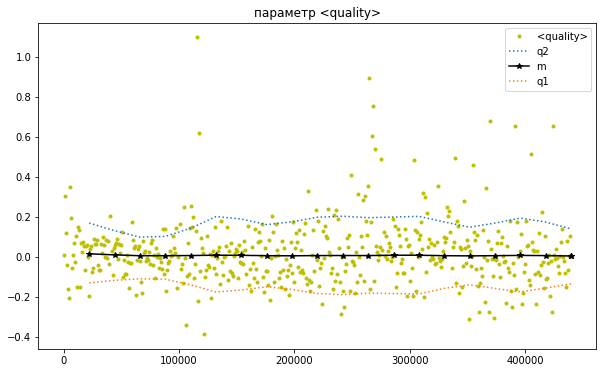

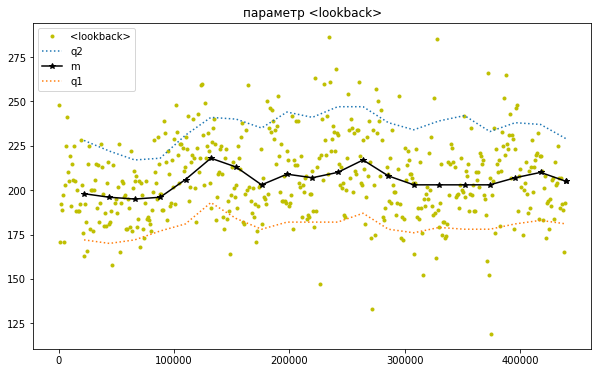

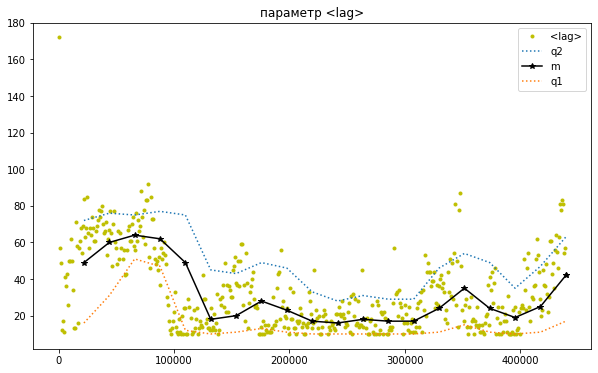

In [116]:
modelGA.plot_hist_new(('quality','lookback','lag'))


## Параметры лучшей

In [117]:
best_par = modelGA.getBestParams()
best_par

{'lag': 60, 'lookback': 192}

# Прогон лучшей

In [118]:
lookback_best = best_par['lookback']
lag_best = best_par['lag']

s_best = bt.Strategy('лучший', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best*2+lookback_best+1),
                                bt.algos.SelectAll(),
                                bt.algos.WeighMeanVar(lookback=pd.DateOffset(days=lookback_best)),
                                bt.algos.Rebalance()])
test_best = bt.Backtest(s_best, data)

s0 = bt.Strategy('равновесный', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best*2+lookback_best+1),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test0 = bt.Backtest(s0, data)

res_best = bt.run(test_best,test0)

лучший
0% [############################# ] 100% | ETA: 00:00:00равновесный
0% [############################# ] 100% | ETA: 00:00:00

## График баланса

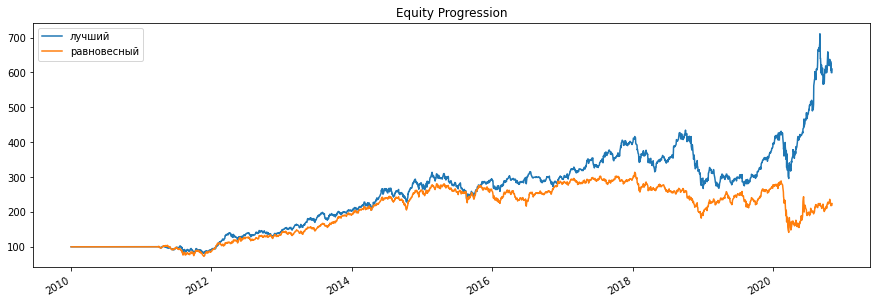

In [119]:
res_best.plot()

## график распределения долей

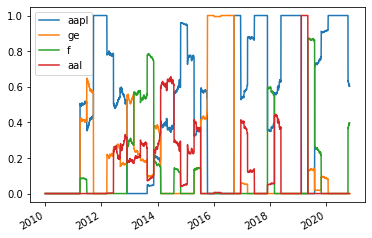

In [120]:
res_best.get_security_weights().plot()

## итог

In [121]:
res_best.display()

Stat                 лучший      равновесный
-------------------  ----------  -------------
Start                2010-01-03  2010-01-03
End                  2020-11-03  2020-11-03
Risk-free rate       0.00%       0.00%

Total Return         509.61%     123.78%
Daily Sharpe         0.80        0.42
Daily Sortino        1.29        0.68
CAGR                 18.16%      7.72%
Max Drawdown         -38.52%     -54.94%
Calmar Ratio         0.47        0.14

MTD                  1.64%       2.39%
3m                   5.84%       12.46%
6m                   59.98%      35.49%
YTD                  57.48%      -17.09%
1Y                   80.25%      -12.55%
3Y (ann.)            15.35%      -8.47%
5Y (ann.)            17.08%      -4.09%
10Y (ann.)           19.81%      8.39%
Since Incep. (ann.)  18.16%      7.72%

Daily Sharpe         0.80        0.42
Daily Sortino        1.29        0.68
Daily Mean (ann.)    19.73%      10.50%
Daily Vol (ann.)     24.60%      24.77%
Daily Skew           -0.07  

Енин А.В.

Оренбург